# CSCA 5642 Introduction to Deep Learning Week 3 Homework

## Preparation

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt
import tensorflow as tf

# fix random seed for reproducibility
SEED = 0
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

2024-02-29 10:51:11.689003: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 10:51:11.711663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
project_root = '/home/lee/Documents/CSCA5642/week3/'
data_folder = os.path.join(project_root, 'histopathologic-cancer-detection')
train_dir = os.path.join(data_folder, 'train')
test_dir = os.path.join(data_folder, 'test')
model_folder = os.path.join(project_root, 'models')
y = pd.read_csv(os.path.join(data_folder, 'train_labels.csv'))

## Description of the problem and data



**Data source**: https://www.kaggle.com/c/histopathologic-cancer-detection/

**Challenge problem**: This is a binary image classification problem. The input dataset contains small images taken from larger digital pathology scans. Our task is to use deep learning techniques to identify metastatic cancer from these images. 

### Size

In [3]:
# Get a list of all files in the folder
train_list = os.listdir(train_dir)
train_images = [file for file in train_list if file.endswith(".tif")]
print(f'number of training files {len(train_images)}')

test_list = os.listdir(test_dir)
test_images = [file for file in test_list if file.endswith(".tif")]
print(f'number of test files {len(test_images)}')

number of training files 220025
number of test files 57458


### Image dimension and data dimension

Training image sample


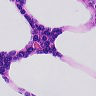

Training image size: 96, 96


In [4]:
def find_image_size(image_dir, image_list):
    sample_image = image_list[0]

    # Open and display the sample image
    with Image.open(os.path.join(image_dir, sample_image)) as img:
        display(img)
        img_width, img_height = img.size

    return img_width, img_height
    
print('Training image sample')
img_width, img_height = find_image_size(train_dir, train_images)
print(f"Training image size: {img_width}, {img_height}")

In [5]:
del train_list, train_images, test_list, test_images 

In [6]:
print(f'shape of the labels dataframe {y.shape}')

shape of the labels dataframe (220025, 2)


### Structure

In [7]:
print(f'preview of the labels dataframe \n {y.head()}')

preview of the labels dataframe 
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Exploratory Data Analysis (EDA)  

### Inspect the data

In [8]:
print(y['label'].value_counts())

label
0    130908
1     89117
Name: count, dtype: int64


In [9]:
y['label'].value_counts(normalize=True)

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

The classes are reasonably balanced.

### Visualize the data

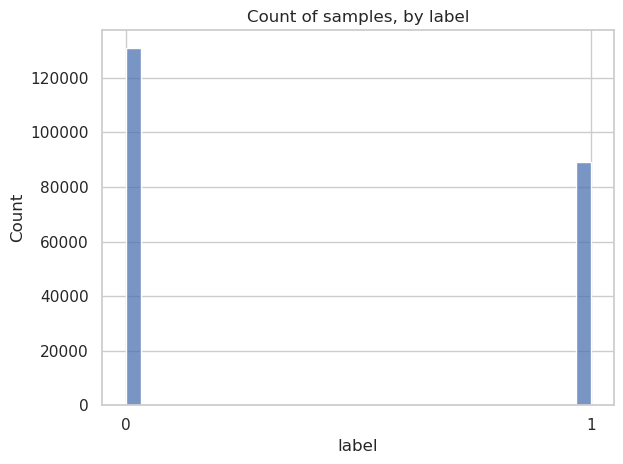

In [45]:
sns.histplot(y, x="label")
plt.xticks([0, 1])
plt.title('Count of samples, by label')
plt.tight_layout()
plt.show()

## Analysis plan

The image files do not require much processing. We will first fit a CNN model to perform this image classification. Then we will fit another CNN model with a different architecture and compare their performances. Then we will perform hyperparameter tuning on the selected model. 

## Model architecture

Convolutional Neural Networks (CNNs) are a type of deep learning model commonly used for image-related tasks, thanks to its ability to automatically learn spatial hierarchies of features. We choose CNNs for this project as they have been highly successful in various tasks such as image classification, image recognition, and object detection, 

Architecture-wise, CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. Convolutional layers apply a series of filters (kernels) to input images to detect features like edges and textures. Pooling layers then downsample the feature maps generated by convolutional layers to reduce computational complexity and control overfitting. Finally, fully connected layers process the high-level features extracted by previous layers to make predictions.

### Helper functions

In [46]:
def summarize_history(model_history):
    """Plot the relationship between the number of epochs and the selected model performance metric.
    This plot can inform us whether we should train the model using more or fewer epochs. 
    """
    sns.lineplot(model_history.history['accuracy'], color='blue', label='train')
    sns.lineplot(model_history.history['val_accuracy'], color='green', label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')

### CNN model

In popular CNN model architectures, we often see blocks of a couple of convolutional layers and then a pooling layer. When moving closer to the output there are usually fully connected layers. It is My first model contains 4 pairs of convolutional and maxpooling layers, before the fully connected layers.

In [12]:
input_shape = (img_width, img_height, 3)

In [13]:
model_conv4 = models.Sequential()
model_conv4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_conv4.add(layers.MaxPooling2D((2, 2)))
model_conv4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv4.add(layers.MaxPooling2D((2, 2)))
model_conv4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv4.add(layers.MaxPooling2D((2, 2)))
model_conv4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv4.add(layers.MaxPooling2D((2, 2)))
model_conv4.add(layers.Flatten())
model_conv4.add(layers.Dense(512, activation='relu'))
model_conv4.add(layers.Dense(1, activation='sigmoid'))

model_conv4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

2024-02-29 10:51:38.229679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 10:51:38.243869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 10:51:38.243999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Model comparison

Here we build another CNN model by adding another pair of convolutional and maxpooling layers.

In [14]:
model_conv5 = models.Sequential()
model_conv5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_conv5.add(layers.MaxPooling2D((2, 2)))
model_conv5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv5.add(layers.MaxPooling2D((2, 2)))
model_conv5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv5.add(layers.MaxPooling2D((2, 2)))
model_conv5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv5.add(layers.MaxPooling2D((2, 2)))
model_conv5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv5.add(layers.MaxPooling2D((2, 2)))
model_conv5.add(layers.Flatten())
model_conv5.add(layers.Dense(512, activation='relu'))
model_conv5.add(layers.Dense(1, activation='sigmoid'))

model_conv5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Results and analysis 

### Prepare the training data

In [15]:
y = y.astype('str')
y['id'] += '.tif'

In [16]:
# Parameters
batch_size = 32
epochs = 10

In [17]:
x_train = ImageDataGenerator(
    validation_split = 0.2
).flow_from_dataframe(
    dataframe = y,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    subset = 'training'
)

x_val = ImageDataGenerator(
    validation_split = 0.2
).flow_from_dataframe(
    dataframe = y,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    subset = 'validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Train the models

In [21]:
history_conv4 = model_conv4.fit(
    x_train,
    steps_per_epoch=x_train.samples // batch_size,
    epochs=epochs,
    validation_data=x_val,
    validation_steps=x_val.samples // batch_size)

Epoch 1/10
5500/5500 [==============================] - 41s 7ms/step - loss: 0.2143 - accuracy: 0.9172 - val_loss: 0.2543 - val_accuracy: 0.8941
Epoch 2/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.2065 - accuracy: 0.9193 - val_loss: 0.2403 - val_accuracy: 0.9120
Epoch 3/10
5500/5500 [==============================] - 41s 8ms/step - loss: 0.1999 - accuracy: 0.9228 - val_loss: 0.2600 - val_accuracy: 0.9013
Epoch 4/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.2021 - accuracy: 0.9218 - val_loss: 0.2460 - val_accuracy: 0.9075
Epoch 5/10
5500/5500 [==============================] - 41s 8ms/step - loss: 0.1909 - accuracy: 0.9269 - val_loss: 0.2687 - val_accuracy: 0.8854
Epoch 6/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.1837 - accuracy: 0.9300 - val_loss: 0.2456 - val_accuracy: 0.9127
Epoch 7/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.1773 - accuracy: 0.9322 - val_loss: 0.2771 - val_ac

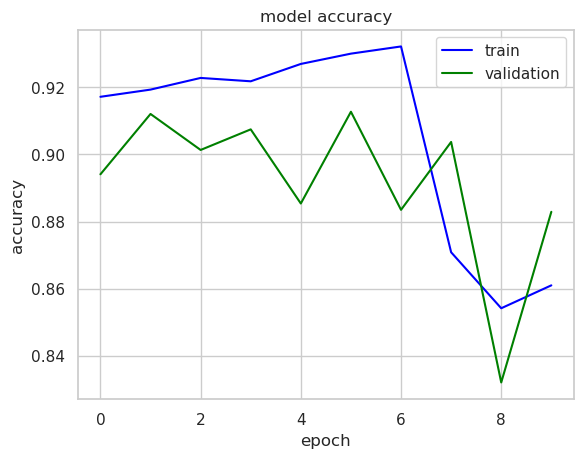

In [32]:
summarize_history(history_conv4)

In [23]:
history_conv5 = model_conv5.fit(
    x_train,
    steps_per_epoch=x_train.samples // batch_size,
    epochs=epochs,
    validation_data=x_val,
    validation_steps=x_val.samples // batch_size)

Epoch 1/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.2681 - accuracy: 0.9079 - val_loss: 0.2303 - val_accuracy: 0.9104
Epoch 2/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.1902 - accuracy: 0.9265 - val_loss: 0.2378 - val_accuracy: 0.9027
Epoch 3/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.2006 - accuracy: 0.9210 - val_loss: 0.3194 - val_accuracy: 0.8744
Epoch 4/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.2005 - accuracy: 0.9223 - val_loss: 0.2181 - val_accuracy: 0.9168
Epoch 5/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.1689 - accuracy: 0.9358 - val_loss: 0.2139 - val_accuracy: 0.9194
Epoch 6/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.1729 - accuracy: 0.9335 - val_loss: 0.2410 - val_accuracy: 0.9108
Epoch 7/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.1684 - accuracy: 0.9353 - val_loss: 0.2159 - val_ac

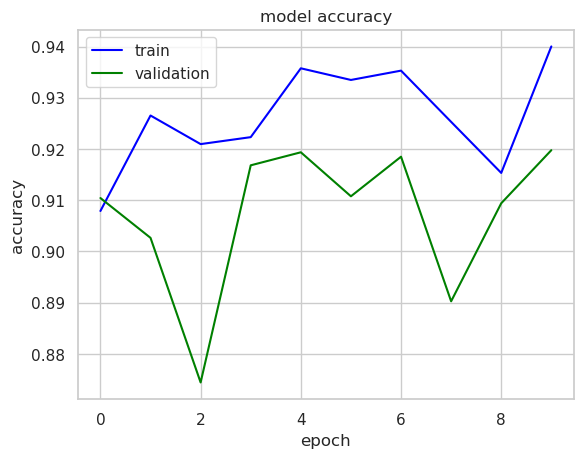

In [33]:
summarize_history(history_conv5)

The model with the extra convolutional-pooling pair performs better than the other one. Next we will further optimize it via hyperparameter tuning.

### Hyperparameter optimization

Here we will search for optimal number of units in the fully connected layer and learning rate. 

In [34]:
def model_builder(hp):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
    model.add(layers.Dense(hp_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [35]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=epochs,
                     factor=3,
                     )

In [36]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [38]:
tuner.search(x_train, epochs=epochs, validation_data=x_val, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the last dense
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 12m 31s]
val_accuracy: 0.5961368083953857

Best val_accuracy So Far: 0.9184183478355408
Total elapsed time: 01h 30m 20s

The hyperparameter search is complete. The optimal number of units in the last dense
layer is 384 and the optimal learning rate for the optimizer
is 0.001.



In [40]:
# Build the model with the optimal hyperparameters 
model_tuned = tuner.hypermodel.build(best_hps)
history_tuned = model_tuned.fit(
    x_train,
    steps_per_epoch=x_train.samples // batch_size,
    epochs=epochs,
    validation_data=x_val,
    validation_steps=x_val.samples // batch_size)

Epoch 1/10
5500/5500 [==============================] - 42s 7ms/step - loss: 0.4623 - accuracy: 0.7945 - val_loss: 0.4461 - val_accuracy: 0.8061
Epoch 2/10
5500/5500 [==============================] - 42s 8ms/step - loss: 0.3555 - accuracy: 0.8475 - val_loss: 0.3140 - val_accuracy: 0.8696
Epoch 3/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.3107 - accuracy: 0.8700 - val_loss: 0.3065 - val_accuracy: 0.8723
Epoch 4/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.2842 - accuracy: 0.8837 - val_loss: 0.2951 - val_accuracy: 0.8740
Epoch 5/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.2608 - accuracy: 0.8937 - val_loss: 0.2684 - val_accuracy: 0.8947
Epoch 6/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.2455 - accuracy: 0.9009 - val_loss: 0.2778 - val_accuracy: 0.8878
Epoch 7/10
5500/5500 [==============================] - 43s 8ms/step - loss: 0.2329 - accuracy: 0.9078 - val_loss: 0.2653 - val_ac

In [44]:
model_tuned.save(os.path.join(model_folder, 'image_classifier_model.keras'))

### Summary

| Algorithm | Accuracy (in validation data) |
| --- | ----------- |
| CNN model with 4 convolutional-pooling pairs | 0.8829 |
| CNN model with 5 convolutional-pooling pairs | 0.9198 |
| CNN model with 5 convolutional-pooling pairs and hyperparameter optimization | 0.9148 |

**What helped**: Including more convolutional layers in the architecture. 

## Conclusion

**What improved model performance**: Including more convolutional-pooling layer pairs in the model. 

**What did not help improve model performance**: Hyperparameter tuning, specifically, tuning the number of units in the fully connected layer and the learning rate. 

**Improvements to try in the future**:
* tune other hyperparameters, such as the convolutional layer's kernel size, stride, etc.
* add normalization layers
* add more fully connected layers before the output
* add more convolutional layers to the model

In [41]:
y_test = pd.read_csv(os.path.join(data_folder, 'sample_submission.csv'))

y_test = y_test.astype('str')
y_test['id'] += '.tif'

# Ensure shuffle = False
x_test = ImageDataGenerator(
).flow_from_dataframe(
    dataframe = y_test,
    directory = test_dir,
    x_col = 'id',
    y_col = None,
    target_size = (96, 96),
    class_mode = None,
    shuffle = False
)

Found 57458 validated image filenames.


In [42]:
pred_labels = model_tuned.predict(x_test)

submit = pd.DataFrame()
submit['id'] = y_test['id'].str.partition('.')[0]
submit['label'] = pred_labels[:, 0]
submit.to_csv(os.path.join(project_root, 'submit.csv'), index = False)

1796/1796 [==============================] - 727s 405ms/step
